<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Extract-Data" data-toc-modified-id="Extract-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extract Data</a></span></li><li><span><a href="#Clean-&amp;-Merge-Datasets" data-toc-modified-id="Clean-&amp;-Merge-Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean &amp; Merge Datasets</a></span><ul class="toc-item"><li><span><a href="#Get-Generator-Info-from-Excel" data-toc-modified-id="Get-Generator-Info-from-Excel-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Get Generator Info from Excel</a></span></li><li><span><a href="#Filter-Out-Renewables-Data-&amp;-Merge" data-toc-modified-id="Filter-Out-Renewables-Data-&amp;-Merge-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Filter Out Renewables Data &amp; Merge</a></span></li></ul></li><li><span><a href="#View-Data" data-toc-modified-id="View-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>View Data</a></span></li><li><span><a href="#Interaction-with-R" data-toc-modified-id="Interaction-with-R-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Interaction with R</a></span><ul class="toc-item"><li><span><a href="#Non-Renewable-Production" data-toc-modified-id="Non-Renewable-Production-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Non-Renewable Production</a></span></li><li><span><a href="#Exploratory-Analysis" data-toc-modified-id="Exploratory-Analysis-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Exploratory Analysis</a></span><ul class="toc-item"><li><span><a href="#Wind-Production" data-toc-modified-id="Wind-Production-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Wind Production</a></span></li><li><span><a href="#Select-Optimal-Fourier-Series" data-toc-modified-id="Select-Optimal-Fourier-Series-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Select Optimal Fourier Series</a></span></li></ul></li><li><span><a href="#Renewable-Production-Forecasting" data-toc-modified-id="Renewable-Production-Forecasting-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Renewable Production Forecasting</a></span><ul class="toc-item"><li><span><a href="#Expected-vs.-Unexpected-Model" data-toc-modified-id="Expected-vs.-Unexpected-Model-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Expected vs. Unexpected Model</a></span></li></ul></li></ul></li></ul></div>

# Imports

In [2]:
from itertools import permutations, product
from functools import reduce
import os, sys

import numpy as np, pandas as pd, dask.dataframe as ddf
from pyspark.sql import SparkSession
import os, sys, socket

cName = socket.gethostname()

scriptDir = os.path.dirname(os.path.realpath(sys.argv[0]))   # get script directory
if cName == 'DESKTOP-HOKP1GT': 
    genDir = "C:/Users/benmo/OneDrive/GitHub/DataPlayground" #get general functions path
    os.chdir(genDir)
    
elif sys.platform == 'linux':
    genDir = "/home/benmo/OneDrive/GitHub/DataPlayground" #get general functions path
    os.chdir(genDir)
else: 
    genDir = "D:/benmo/OneDrive/GitHub/DataPlayground"
    os.chdir(genDir)


from General import * # import custom 'general' functions

os.chdir(scriptDir)



# Extract Data

  * first run webscraping algorith to collect hourly prices from [http://ets.aeso.ca/](http://ets.aeso.ca/) 
  * clean & combine files as follows:


In [3]:
generators = pd.read_excel(
    "/home/benmo/OneDrive/GitHub/Research/Electricity/Alberta Electricity/Electricity.xlsm", 
    sheet_name='GenList')

generators.ID = generators.ID.apply(lambda x: re.sub('([()])','', x))
generators['wind_solar'] = (generators.TYPE == 'WIND') | (generators.ASSET == 'Brooks Solar ')
generators['Gas_ss'] = (generators.TYPE == 'GAS (SIMPLE CYCLE)')
generators['Gas_cc'] = (generators.TYPE == 'GAS (COMBINED CYCLE)')
generators['Gas_cogen'] = (generators.TYPE == 'GAS (COGENERATION)')
generators['Coal'] = (generators.TYPE == 'COAL')
generators['Hydro'] = (generators.TYPE == 'HYDRO')
generators['Other'] = (generators.TYPE == 'BIOMASS/OTHER')




In [4]:
genType = {}
    
for gType in generators[['wind_solar','Gas_ss', 'Gas_cc', 'Gas_cogen','Coal',
                         'Hydro', 'Other']].columns:
    genType[gType] = generators[
            generators[gType] == True].ID.unique().tolist()

In [5]:
spark = SparkSession.builder.appName(
        'myspark').master("local[4]").config(
                "spark.ui.enabled","false").config(
                        "spark.driver.extraClassPath",
                        "/home/benmo/DB_drivers/sqlite-jdbc-3.16.1.jar").config(
                                "spark.executor.extraClassPath", 
                                "/home/benmo/DB_drivers/sqlite-jdbc-3.16.1.jar").getOrCreate()

In [5]:
aeso_ddf = ddf.read_csv('/home/benmo/Data/Electricity/*.csv',skiprows=2,dtype={'Date': str,
                                                    'HE': str,
                                                   'Import/Export': str,
                                                   'Asset Id': str,
                                                   'Block Number': str,
                                                   'Price': 'float64',
                                                    'From': 'int64', 
                                                    'To': 'int64',
                                                    'Size': 'int64', 
                                                    'Available': 'int64',
                                                    'Dispatched': str, 
                                                    'Dispatched MW': 'int64',
                                                   'Flexible': str,
                                                    'Effective Date/Time': str,
                                                   'Offer Control': str})





In [7]:
aeso_df.to_parquet('/home/benmo/Data/Electricity/AlbertaMO.parquet',  compression='gzip')

In [13]:
aeso = spark.read.format("csv").option("header", "true").load(
    "/home/benmo/Data/Electricity/*.csv")

StructType(List(StructField(Energy Merit Order Snapshot Report,StringType,true)))

In [ ]:
"""_____________________________MERIT ORDER DATA___________________________________________"""
aeso_ddf = ddf.read_csv('Z:/Electricity/*.csv',skiprows=2,dtype={'Date': str,
                                                    'HE': str,
                                                   'Import/Export': str,
                                                   'Asset Id': str,
                                                   'Block Number': str,
                                                   'Price': 'float64',
                                                    'From': 'int64', 
                                                    'To': 'int64',
                                                    'Size': 'int64', 
                                                    'Available': 'int64',
                                                    'Dispatched': str, 
                                                    'Dispatched MW': 'int64',
                                                   'Flexible': str,
                                                    'Effective Date/Time': str,
                                                   'Offer Control': str})
    
aeso_ddf['Effective Date/Time'] = ddf.to_datetime(aeso_ddf['Effective Date/Time'], 
                                                  errors='coerce')
aeso_ddf = aeso_ddf[aeso_ddf[
    'Effective Date/Time'].isnull() == False].set_index('Effective Date/Time')

aeso = aeso_ddf.compute().sort_index()


"""______________________________GET FORECAST DATA________________________________________"""
fileList = os.listdir("Z:/Electricity/forecast") #read list of csv files

#MERGE THE DATA
aeso_fcst = reduce(lambda x,y: x.append(y,ignore_index=True), 
             list(map(lambda x: pd.read_csv(
                    "Z:/Electricity/forecast/" + x, skiprows=4).rename(
                    columns={' Day-Ahead Forecasted AIL' : 'Day-Ahead Forecasted AIL',
                    'Forecast Pool Price' : 'Day Ahead Forecast Pool Price'}), fileList)))

#CLEAN THE DATA
aeso_fcst.drop(columns=['Forecasted & Actual AIL Difference', 
                        'Real Time Forecast Pool Price'],inplace=True)
aeso_fcst.Date = aeso_fcst.Date.astype(str)
aeso_fcst.Date[aeso_fcst.Date.apply(lambda x: x[-2:]) == '24'] = aeso_fcst.Date[
        aeso_fcst.Date.apply(lambda x: x[-2:]) == '24'].apply(lambda x: x[:-2] + '00')

aeso_fcst = aeso_fcst.set_index('Date')
aeso_fcst.index = pd.to_datetime(aeso_fcst.index, format='%m/%d/%Y %H', errors='coerce')
aeso_fcst = aeso_ddf[aeso_fcst.index.notna() == True]
aeso_fcst['Date1'] = aeso_fcst.index
aeso_fcst = aeso_fcst.sort_index()
aeso_fcst.set_index(aeso_fcst.index + pd.to_timedelta(30,unit = 'm'), inplace=True)
    


# Clean & Merge Datasets

## Get Generator Info from Excel 

In [2]:
generators = pd.read_excel(MyComp.classesPath + "/Energy Econ/" + 
                               "Research Papers/Electricity/Electricity.xlsm", sheet_name='GenList')
    
generators.ID = generators.ID.apply(lambda x: re.sub('([()])','', x))
generators['wind_solar'] = (generators.TYPE == 'WIND') | (generators.ASSET == 'Brooks Solar ')


renewID = generators[generators['wind_solar'] == True].ID.unique().tolist()

## Filter Out Renewables Data & Merge 

In [ ]:
aeso_rnw = aeso[aeso['Asset Id'].apply(lambda x: x in renewID)]
aeso_rnw_prod = aeso_rnw[['Price','Available MW', 'Dispatched MW']].groupby(aeso_rnw.index).sum()

aeso_rnw_prod['Dispatched MW'][aeso_rnw_prod['Dispatched MW'] > 2000] = aeso_rnw_prod[
        'Dispatched MW'][aeso_rnw_prod['Dispatched MW'] > 2000].apply(lambda x: x/2)

aeso_rnw_prod = aeso_rnw_prod['2015':]
aeso_rnw_prod['Date'] = aeso_rnw_prod.index
aeso_rnw_prod.drop_duplicates(['Date'], inplace=True)

aeso = aeso_fcst['2015':].merge(aeso_rnw_prod, how='inner',left_index=True,right_index=True)

# View Data

In [4]:
try:
    aeso
except:
    aeso = pd.read_pickle("D:/Data/PyObjects/aesoRenew.pkl")

In [8]:
aeso.drop(columns=['Date1','Price', 'Available MW'], inplace=True)
aeso[aeso.columns[:-1]] = aeso[aeso.columns[:-1]].astype(str).applymap(lambda x: x.replace(',', ''))
aeso[aeso.columns[:-1]] = aeso[aeso.columns[:-1]].apply(pd.to_numeric, errors='coerce')
aeso

,Actual AIL,Actual Posted Pool Price,Day Ahead Forecast Pool Price,Day-Ahead Forecasted AIL,Dispatched MW,Date
2015-04-01 00:30:00,8830,18.85,18.92,8691,1375,2015-04-01 00:30:00
2015-04-01 01:30:00,8434,14.10,0.00,8401,1375,2015-04-01 01:30:00
2015-04-01 02:30:00,8279,15.56,12.62,8272,1375,2015-04-01 02:30:00
2015-04-01 03:30:00,8231,17.83,19.03,8201,1375,2015-04-01 03:30:00
2015-04-01 04:30:00,8245,19.17,19.33,8185,1375,2015-04-01 04:30:00
2015-04-01 05:30:00,8306,20.09,20.92,8234,1375,2015-04-01 05:30:00
2015-04-01 06:30:00,8534,20.43,20.67,8452,1375,2015-04-01 06:30:00
2015-04-01 07:30:00,9003,23.81,25.41,8961,1375,2015-04-01 07:30:00
2015-04-01 08:30:00,9403,22.27,23.00,9331,1364,2015-04-01 08:30:00
2015-04-01 09:30:00,9518,22.26,22.30,9470,1362,2015-04-01 09:30:00


In [9]:
aeso.dtypes

Actual AIL                                int64
Actual Posted Pool Price                float64
Day Ahead Forecast Pool Price           float64
Day-Ahead Forecasted AIL                  int64
Dispatched MW                             int64
Date                             datetime64[ns]
dtype: object

In [3]:
aeso.columns

Index(['Actual AIL', 'Actual Posted Pool Price',
       'Day Ahead Forecast Pool Price', 'Day-Ahead Forecasted AIL', 'Date1',
       'Price', 'Available MW', 'Dispatched MW', 'Date'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B8855D4F60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B88593CC88>]], dtype=object)

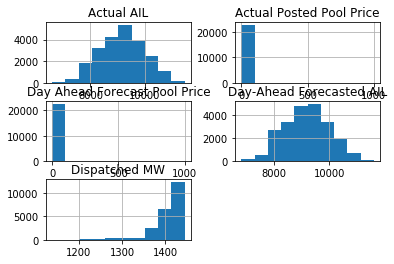

In [22]:
aeso[aeso.columns[:-1]].hist()

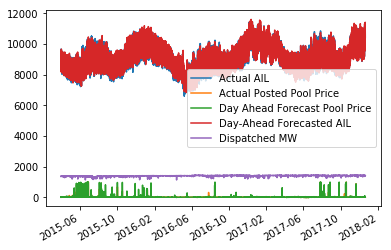

In [24]:
aeso[aeso.columns[:-1]].plot.line()

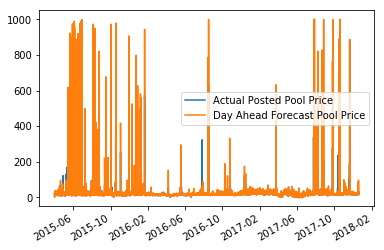

In [27]:
aeso[['Actual Posted Pool Price',
       'Day Ahead Forecast Pool Price']].plot.line()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000241B053C400>,
      dtype=object)

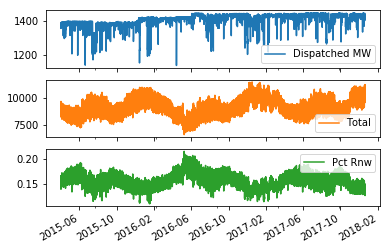

In [20]:
Prod = pd.DataFrame(aeso['Dispatched MW'])
Prod['Total'] = aeso['Actual AIL']
Prod['Pct Rnw'] = Prod['Dispatched MW']/Prod['Total']

Prod.plot.line(subplots=True)

# Interaction with R

In [28]:
%R -n -i aeso
%R aeso

,Actual.AIL,Actual.Posted.Pool.Price,Day.Ahead.Forecast.Pool.Price,Day.Ahead.Forecasted.AIL,Dispatched.MW,Date
2015-04-01 00:30:00,8830,18.85,18.92,8691,1375,1.427870e+09
2015-04-01 01:30:00,8434,14.10,0.00,8401,1375,1.427873e+09
2015-04-01 02:30:00,8279,15.56,12.62,8272,1375,1.427877e+09
2015-04-01 03:30:00,8231,17.83,19.03,8201,1375,1.427881e+09
2015-04-01 04:30:00,8245,19.17,19.33,8185,1375,1.427884e+09
2015-04-01 05:30:00,8306,20.09,20.92,8234,1375,1.427888e+09
2015-04-01 06:30:00,8534,20.43,20.67,8452,1375,1.427891e+09
2015-04-01 07:30:00,9003,23.81,25.41,8961,1375,1.427895e+09
2015-04-01 08:30:00,9403,22.27,23.00,9331,1364,1.427899e+09
2015-04-01 09:30:00,9518,22.26,22.30,9470,1362,1.427902e+09


<u>Save to an R Workspace </u>

In [30]:
%R -n save.image('D:/benmo/OneDrive/GitHub/DataPlayground/R/electricity.RData')

In [6]:
aeso_non_rnw = aeso[aeso['Asset Id'].apply(lambda x: x not in renewID)]

In [5]:
aeso = pd.read_pickle("D:/data/pyobjects/aesomeritorder.pkl") #reload if necessary


## Non-Renewable Production

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


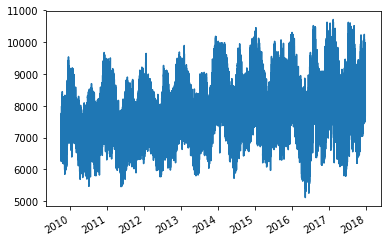

In [16]:
aeso_temp = aeso_non_rnw[['Price','Available MW', 'Dispatched MW']].groupby(aeso_non_rnw.index).sum()

aeso_temp['Dispatched MW'][aeso_temp['Dispatched MW'] > 11000] = aeso_temp[
        'Dispatched MW'][aeso_temp['Dispatched MW'] > 11000].apply(lambda x: x/2)

aeso_temp['Date'] = aeso_temp.index
aeso_temp.drop_duplicates(['Date'], inplace=True)
aeso_temp['Dispatched MW'][(aeso_temp['Dispatched MW'] > 11000) | (aeso_temp['Dispatched MW'] < 500)] = aeso_temp['Dispatched MW'].mean()

aeso_temp['Dispatched MW'].plot()

In [35]:
aesoPrice = pd.read_pickle("D:/Data/PyObjects/aesoforecast.pkl")

aeso_temp['Non Rnw MW'] = aeso_temp['Dispatched MW']

data_NR = aeso_non_rnw.merge(pd.DataFrame(aeso_temp['Non Rnw MW']), how='inner', left_index=True, right_index=True)
data_NR = data_NR.merge(aesoPrice.drop(columns='Date1',axis=1), how='inner', left_index=True, right_index=True)

In [36]:
data_NR

,HE,Import/Export,Asset Id,Block Number,Price,From,To,Size,Available MW,Dispatched,Dispatched MW,Flexible,Offer Control,Non Rnw MW,Actual AIL,Actual Posted Pool Price,Day Ahead Forecast Pool Price,Day-Ahead Forecasted AIL
2009-10-01 00:30:00,1,NaN,SH1,6,49.06,350,390,40,40,N,0,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,TC01,0,0.00,0,64,64,64,Y,64,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,BR4,0,0.00,0,60,60,60,Y,60,N,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,SCL1,0,0.00,0,48,48,48,Y,48,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,SH1,0,0.00,0,135,135,135,Y,135,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,HRM,1,0.10,45,90,45,45,Y,45,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,GN3,2,7.80,313,410,97,97,Y,97,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,SH1,4,22.44,250,312,62,62,N,0,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,SD1,2,22.68,220,240,20,20,N,0,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"
2009-10-01 00:30:00,1,NaN,SCR1,1,23.33,333,391,58,58,N,0,Y,NaN,6438.0,"7,308",11.74,13.48,"7,323"


In [40]:
data_NR['Actual Posted Pool Price'].apply(pd.to_numeric).describe()

count    1.184607e+07
mean     4.715496e+01
std      1.095806e+02
min      0.000000e+00
25%      1.771000e+01
50%      2.354000e+01
75%      3.499000e+01
max      1.000000e+03
Name: Actual Posted Pool Price, dtype: float64

In [44]:
data_NR[['Actual Posted Pool Price','Dispatched MW','Price']]=data_NR[
    ['Actual Posted Pool Price','Dispatched MW','Price']].apply(pd.to_numeric)

In [67]:
temp = data_NR[((data_NR['Actual Posted Pool Price'] > 35) & (data_NR.Dispatched == 'Y')) & (data_NR.Price > 500)]
temp

,HE,Import/Export,Asset Id,Block Number,Price,From,To,Size,Available MW,Dispatched,Dispatched MW,Flexible,Offer Control,Non Rnw MW,Actual AIL,Actual Posted Pool Price,Day Ahead Forecast Pool Price,Day-Ahead Forecasted AIL
2009-10-04 17:30:00,18,E,PW20,0,999.99,0,22,22,22,Y,22,Y,NaN,7451.0,"8,113",38.11,32.17,"7,796"
2009-10-08 00:30:00,1,E,PW20,0,999.99,0,227,227,227,Y,227,Y,NaN,6978.0,"7,766",37.09,37.1,"7,655"
2009-10-08 23:30:00,24,E,PW20,0,999.99,0,100,100,100,Y,100,Y,NaN,6930.0,"7,959",44.11,42.69,"7,987"
2009-10-09 23:30:00,24,E,PW20,0,999.99,0,50,50,50,Y,50,Y,NaN,7085.0,"8,044",42.78,42.58,"7,966"
2009-10-10 00:30:00,1,E,PW20,0,999.99,0,100,100,100,Y,50,Y,NaN,6900.0,"7,697",35.95,37.27,"7,691"
2009-10-10 02:30:00,3,E,PW20,0,999.99,0,250,250,250,Y,50,Y,NaN,6973.0,"7,453",35.08,27.91,"7,348"
2009-10-10 23:30:00,24,E,PW20,0,999.99,0,50,50,50,Y,50,Y,NaN,6949.0,"7,990",44.19,44.94,"7,912"
2009-10-11 00:30:00,1,E,PW20,0,999.99,0,100,100,100,Y,100,Y,NaN,6916.0,"7,721",36.87,39.25,"7,706"
2009-10-11 07:30:00,8,E,EMXB,0,999.99,0,150,150,150,Y,150,Y,NaN,7118.0,"7,284",36.77,35.75,"7,479"
2009-10-11 07:30:00,8,E,PW20,0,999.99,0,75,75,75,Y,75,Y,NaN,7118.0,"7,284",36.77,35.75,"7,479"


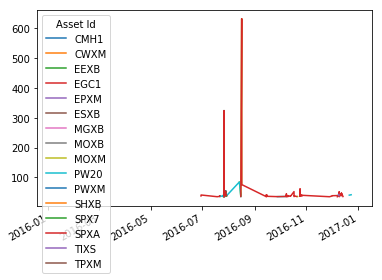

In [74]:
temp1 = pd.pivot_table(temp[['Actual Posted Pool Price','Asset Id']], index=temp.index, values='Actual Posted Pool Price',
                                                        columns='Asset Id', aggfunc=np.mean)
temp1['2016'].dropna(axis=1, how='all').plot.line()

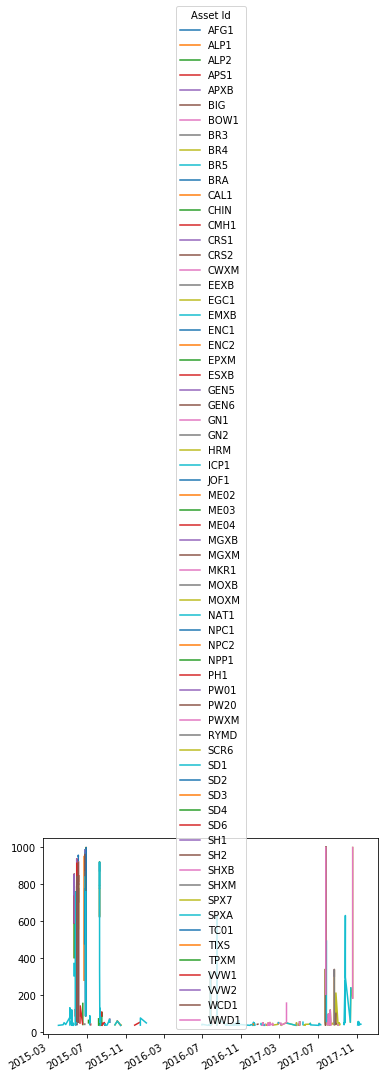

In [83]:
temp1['2015-04-01':'2018'].dropna(axis=1, how='all').plot.line()

In [82]:
temp1.notna().sum().to_csv('C:/Users/benmo/OneDrive/2016& 2017Classes/Energy Econ/Research Papers/Electricity/HighCost.csv')

In [85]:
temp1['2015-04-01':'2018'].dropna(axis=1, how='all').notna().sum().to_csv('C:/Users/benmo/OneDrive/2016& 2017Classes/Energy Econ/Research Papers/Electricity/HighCost2.csv')

In [ ]:
sns.heatmap(model_lags['AIC'],vmin=7500,vmax=9000, cmap="YlGnBu")

In [ ]:
sns.heatmap(model_lags['BIC'],vmin=7500,vmax=9000, cmap="YlGnBu")

In [ ]:
critList = list(range(35))

ar_model = pd.DataFrame([get_crit(pf.ARIMAX(dataARMA,formula='np.log(Price)~1+AIL+isWkd+m02+m03+m04+m05+m06+m07+m08+m09+m10+m11+m12' +
                                              '+h02+h03+h04+h05+h06+h07+h08+h09+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23+h24',
                                ar=i, ma=0, family=pf.Normal()).fit('MLE')) for i in critList],
             columns=['AIC','BIC'], index=critList)

ar_model.plot()

## Exploratory Analysis

In [48]:
%%R

lapply(list('dplyr','xts', 'rugarch', 'rmgarch', 
            'ggplot2', 'MTS', 'dlm', 'forecast',
            'xtable', 'broom','urca','sgt','fGarch'), require, character.only = TRUE)


if (Sys.getenv('computername') == "DESKTOP-HOKP1GT"){
  load('C:/users/benmo/OneDrive/GitHub/DataPlayground/R/electricity.RData')
} else {
  load('D:/benmo/OneDrive/GitHub/DataPlayground/R/electricity.RData')
}

aeso <- aeso[,1:5]


In [ ]:
x = %R capture.output(summary(aeso))
for line in x: print(line)

In [49]:
%%R


aeso$isWkd <- weekdays(as.POSIXct(rownames(aeso))) %in% c("Friday", "Saturday", "Sunday") == TRUE
aeso$isWkd <- ifelse(aeso$isWkd,1,0)

aeso$Actual.Posted.Pool.Price[aeso$Actual.Posted.Pool.Price < 0.1] = 0.1



x <- msts(aeso$Actual.Posted.Pool.Price, seasonal.periods=c(24, 168, 8760))
fourier_x <- fourier(x, K = c(12,30,2))
aeso <- cbind(aeso, fourier_x)


colnames(aeso) <- c(c('Actual.MW','Actual.Price','Forecast.Price','Forecast.MW','Renewables.MW','isWkd'),
                    colnames(aeso[,7:ncol(aeso)]))



aeso_ts <- na.omit(xts(aeso, as.POSIXct(row.names(aeso))))
aeso <- na.omit(aeso)



In [5]:
%%time 

def test_fit(ar_ord, ma_ord):
    %R -i ar_ord
    %R -i ma_ord

    %R temp <- Arima(log(aeso_ts$Actual.Price), order=c(ar_ord,0,ma_ord), xreg=aeso_ts[,c(1,5:ncol(aeso_ts))], include.drift=T)
    aic = %R temp$aic
    bic = %R temp$bic
    
    return [aic[0], bic[0]]


critList = pd.DataFrame(list(product(list(range(11)),list(range(11))))).apply(np.array).values


fit = pd.DataFrame([test_fit(i,j) for (i,j) in critList],
             columns=['AIC','BIC'], index=[critList[:,0],critList[:,1]])


fit.index.names = ['AR', 'MA']
fit = fit.unstack()

Wall time: 5h 13min 13s


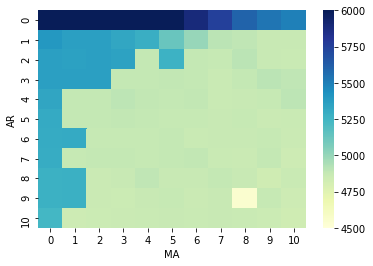

In [14]:
sns.heatmap(fit['AIC'],vmin=4500,vmax=6000, cmap="YlGnBu")

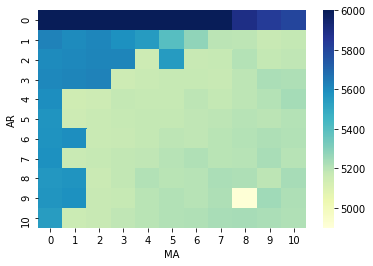

In [12]:
sns.heatmap(fit['BIC'],vmin=4900,vmax=6000, cmap="YlGnBu")

In [9]:
 fit
# AIC & BIC suggest AR9 MA8

AIC                                                       \
MA            0             1            2            3            4    
AR                                                                      
0   27626.703453  14759.027891  9663.582602  7580.681458  6699.317788   
1    5396.886789   5363.194727  5364.700485  5326.481113  5286.917409   
2    5362.717223   5360.062614  5361.940660  5354.116899  4884.479250   
3    5363.847393   5362.142824  5363.308897  4884.574073  4886.596044   
4    5337.210115   4882.136354  4883.955988  4899.523042  4888.019456   
5    5311.978149   4883.935742  4886.141828  4887.532739  4884.568968   
6    5306.711718   5310.758912  4879.794625  4875.416341  4875.387819   
7    5302.180015   4878.208103  4881.264801  4881.601093  4876.920425   
8    5276.398955   5281.538119  4860.062290  4870.640290  4892.995246   
9    5275.169186   5280.390749  4859.589384  4855.805033  4874.051595   
10   5242.083943   4846.302393  4851.577758  4858.581264  4867.543841   

                                                                     \
MA           5            6            7            8            9    
AR                                                                    
0   6226.668176  5890.720670  5758.640943  5604.036570  5540.404055   
1   5128.254340  4998.061803  4909.540429  4897.740954  4869.455534   
2   5270.790034  4882.675102  4878.644364  4907.601582  4870.181151   
3   4888.605815  4881.906689  4867.005239  4881.647330  4907.290767   
4   4880.987314  4889.339443  4868.789265  4871.019369  4880.528410   
5   4875.391825  4877.917383  4871.900478  4877.834209  4860.376262   
6   4881.077299  4868.958086  4874.853701  4872.944872  4877.987488   
7   4885.596639  4889.688508  4864.278705  4862.492131  4881.385803   
8   4873.719528  4870.821369  4881.803329  4870.091244  4834.119333   
9   4876.807893  4862.878009  4872.749266  4549.882929  4879.110514   
10  4871.039353  4865.035078  4871.506931  4866.365356  4851.921739   

       ...                BIC                                         \
MA     ...                 1            2            3            4    
AR     ...                                                             
0      ...       14991.961359  9904.548258  7829.679303  6956.347822   
1      ...        5604.160383  5613.698330  5583.511146  5551.979631   
2      ...        5609.060459  5618.970694  5619.179121  5157.573661   
3      ...        5619.172857  5628.371119  5157.668484  5167.722643   
4      ...        5147.198576  5157.050399  5180.649641  5177.178243   
5      ...        5157.030153  5167.268427  5176.691527  5181.759944   
6      ...        5591.885511  5168.953413  5172.607317  5180.610984   
7      ...        5167.366891  5178.455777  5186.824258  5190.175779   
8      ...        5578.729095  5165.285455  5183.895644  5214.282788   
9      ...        5585.613914  5172.844737  5177.092575  5203.371325   
10     ...        5159.557747  5172.865300  5187.900995  5204.895760   

                                                                     \
MA           5            6            7            8            9    
AR                                                                    
0   6491.730398  6163.815081  6039.767542  5893.195358  5837.595031   
1   5401.348750  5279.188402  5198.699217  5194.931930  5174.678699   
2   5551.916634  5171.833890  5175.835341  5212.824746  5183.436505   
3   5177.764602  5179.097665  5172.228404  5194.902683  5228.578309   
4   5178.178290  5194.562607  5182.044619  5192.306911  5209.848141   
5   5180.614990  5191.172737  5193.188020  5207.153939  5197.728181   
6   5194.332653  5190.245628  5204.173432  5210.296791  5223.371595   
7   5206.884180  5219.008238  5201.630624  5207.876239  5234.802100   
8   5203.039258  5208.173288  5227.187436  5223.507540  5195.567818   
9   5214.159812  5208.262116  5226.165562  4911.331413  5248.591187   
10  5216.423461  5218.451374  5232.955416  5235.846029  5229.43

### Wind Production 

In [50]:
%%R

#____________CREATE DUMMIES FOR WIND PRODUCTION REGIMES_____________
aeso_ts$prod0 <- 0
aeso_ts$prod0['2015-04-01::2015-12-15'] <- 1 

aeso_ts$prod1 <- 0
aeso_ts$prod1['2015-12-15::2016-06-15'] <- 1 

# use columns  7:12, ncol() - 6: ncol()

In [34]:
%R colnames(aeso_ts)

array(['Actual.MW', 'Actual.Price', 'Forecast.Price', 'Forecast.MW',
       'Renewables.MW', 'S1.24', 'C1.24', 'S2.24', 'C2.24', 'S1.8760',
       'C1.8760', 'S2.8760', 'C2.8760'], dtype='<U14')

### Select Optimal Fourier Series 

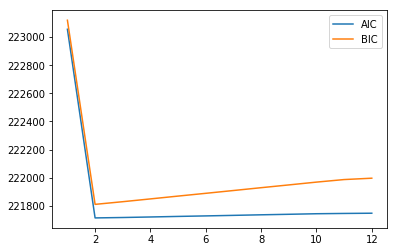

In [51]:

def test_fit(dailyK):
    if dailyK < 10:
        strx = "S[1-{x}][.]|C[1-{x}][.]|prod0|prod1".format(x=dailyK)
    else:
        strx = "S[1-9][.]|C[1-9][.]|S1[0-{x}][.]|C1[0-{x}][.]|prod0|prod1".format(x=int(dailyK-10))
        
    %R -i dailyK
    %R -i strx
    %R indx <- which((grepl('24|8760', colnames(aeso_ts)) & grepl(strx, colnames(aeso_ts))) | grepl('prod0|prod1', colnames(aeso_ts)), TRUE)
    %R exogProd <- aeso_ts[,c(indx)]
    

    %R tempProd <- Arima(aeso_ts$Renewables.MW, order=c(0,0,0), xreg=exogProd)
    aic = %R tempProd$aic
    bic = %R tempProd$bic
    
    return [aic[0], bic[0]]

fitx = pd.DataFrame([test_fit(i) for i in range(1,13)],
             columns=['AIC','BIC'])

fitx.index = [i for i in range(1,13)]

fitx.plot.line()

In [45]:

%R length(ordGARCH)[[1]]

array([1], dtype=int32)

In [18]:

%R indx <- which((grepl('24|8760', 
                        colnames(aeso_ts)) & grepl(
                        'S[1-2][.]|C[1-2][.]',
                        colnames(aeso_ts))) | grepl(
                        'prod0|prod1', colnames(aeso_ts)), TRUE)
%R exogProd <- aeso_ts[,c(indx)]
%R aeso_ts <- aeso_ts[,c(1:5,indx)]


def test_fit(ar_ord, ma_ord):
    %R -i ar_ord
    %R -i ma_ord

    try:
        %R temp <- Arima(aeso_ts$Renewables.MW, order=c(ar_ord,0,ma_ord), xreg=exogProd)
        aic = %R temp$aic
        bic = %R temp$bic
    except:
        aic = [None]
        bic = [None]
    
    return [aic[0], bic[0]]


critList = pd.DataFrame(list(product(list(range(15)),list(range(15))))).apply(np.array).values


fit = pd.DataFrame([test_fit(i,j) for (i,j) in critList],
             columns=['AIC','BIC'], index=[critList[:,0],critList[:,1]])


fit.index.names = ['AR', 'MA']
fit = fit.unstack()


Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE,  : 
  non-finite finite-difference value [11]

Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE,  : 
  non-finite finite-difference value [12]

Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE,  : 
  non-finite finite-difference value [7]

Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE,  : 
  non-finite finite-difference value [14]

Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE,  : 
  non-finite finite-difference value [14]


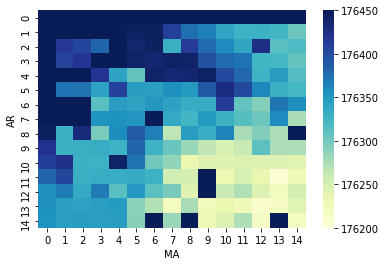

In [32]:
fit = fit.fillna(999999)
sns.heatmap(fit['AIC'],vmin=176200,vmax=176450, cmap="YlGnBu")

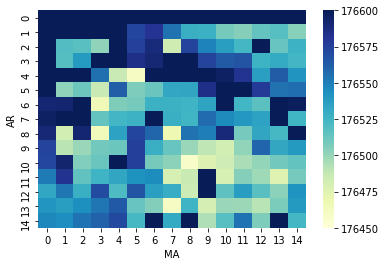

In [27]:
sns.heatmap(fit['BIC'],vmin=176450,vmax=176600, cmap="YlGnBu")

In [21]:
fit

AIC                                                              \
MA             0              1              2              3              4    
AR                                                                              
0   230371.795618  208330.245072  197018.653972  190673.175266  186578.761311   
1   176788.125509  176640.098470  176527.808375  176525.424226  176480.955353   
2   176662.007760  176415.344000  176405.084721  176381.682546  176529.088914   
3   176546.740819  176406.335598  176418.319117  176524.863255  176507.667736   
4   176545.125415  176550.546230  176525.754756  176419.263365  176342.143006   
5   176502.770220  176374.143233  176375.033978  176342.194194  176409.472393   
6   176463.057620  176456.346495  176456.573009  176312.843978  176346.192076   
7   176459.623465  176458.895423  176456.259451  176353.555690  176355.867198   
8   176445.891230  176329.118593  176431.984728  176296.044254  176358.273460   
9   176421.732627  176330.154890  176330.921667  176333.566919  176327.468007   
10  176411.876105  176424.515042  176329.242370  176328.414572  176441.232642   
11  176382.736449  176405.805657  176330.716381  176333.316545  176332.492519   
12  176356.395534  176369.364275  176336.318126  176370.006215  176312.404866   
13  176356.273526  176344.468696  176343.222403  176345.342040  176347.539135   
14  176354.456040  176343.928014  176345.626441  176344.029625  176346.616342   

                                                                               \
MA             5              6              7              8              9    
AR                                                                              
0   184487.666521  182864.977760  181527.138521  180697.275019  179922.552555   
1   176445.003334  176444.612521  176410.335391  176376.059873  176366.901261   
2   176439.075170  176444.303245  176331.171351  176413.745905  176379.897832   
3   176440.292058  176438.082574  176442.243784  176440.608421  176397.187602   
4   176308.225507  176440.653831  176435.593780  176437.598476  176443.907522   
5   176345.751695  176344.466320  176356.355881  176348.654261  176392.052566   
6   176340.144667  176350.882347  176342.663421  176332.846775  176334.085842   
7   176350.600211  176462.427738  176336.164181  176324.395951  176348.418673   
8   176388.878261  176366.886710  176266.962040  176346.562467  176333.495449   
9   176383.508576  176327.864039  176304.914075  176282.401265  176264.730391   
10  176375.424959  176299.838588  176286.321821  176233.044309  176243.639943   
11  176333.837377  176328.574798  176255.097007  176253.007350            NaN   
12  176349.922226  176311.515235  176296.802747  176243.732181            NaN   
13  176288.457222  176272.212324  176219.762526  176277.144685  176224.149073   
14  176290.573167            NaN  176282.115565            NaN  176229.290664   

        ...                  BIC                                               \
MA      ...                   5              6              7              8    
AR      ...                                                                     
0       ...        184608.149350  182993.492777  181663.685726  180841.854413   
1       ...        176573.518351  176581.159726  176554.914785  176528.671456   
2       ...        176575.622375  176588.882639  176483.782934  176574.389676   
3       ...        176584.871452  176590.694156  176602.887555  176609.284381   
4       ...        176460.837089  176601.297602  176604.269739  176614.306624   
5       ...        176506.395466  176513.142279  176533.064029  176533.394597   
6       ...        176508.820627  176527.590495  176527.403758  176525.619300   
7       ...        176527.308359  176647.168074  176528.936706  176525.200665   
8       ...        176573.618597  176559.659235  176467.766753  176555.399369   
9       ...        176576.281101  176528.668753  176513.750977  176499.270356   
10      ...        176576.229673  176508.67

## Renewable Production Forecasting 

In [ ]:
%%R

mdls <- list("sGARCH", "eGARCH")
ordGARCH <- list(c(1,1)) #,c(1,2),c(2,1)
names(ordGARCH) <- c('garch11') #,'garch12','garch21'
ordARMA <- c(11,13) #,c(25,0)
errs <- c("norm","nig","jsu")

spec = list()

for (i in 1:length(mdls)){
  spec[[i]] <- list()
  for (j in 1:length(ordGARCH)){
    spec[[i]][[j]] <- list()
    
    for (k in 1:length(errs)){
      spec[[i]][[j]][[k]] <- ugarchspec(variance.model = list(model = mdls[[i]], 
                                          garchOrder = ordGARCH[[j]],
                                          variance.targeting = FALSE),
                    mean.model = list(armaOrder = ordARMA, 
                                      include.mean = TRUE,
                                      archm = TRUE, archpow = 1, #incl. ARCH (wind turbines might need t to speed up)
                                      arfima = FALSE, 
                                      external.regressors = aeso_ts[,c(6:ncol(aeso_ts))], 
                                      archex = FALSE), 
                    distribution.model = errs[k])
    }
  }
}

names(spec) <- c("sGARCH", "eGARCH")


fitRnw <- spec

for (i in 1:length(mdls)){
  for (j in 1:length(ordGARCH)){
    for (k in 1:length(errs)){
      fitRnw[[i]][[j]][[k]] <- tryCatch(
                                    ugarchfit(data = aeso_ts$Renewables.MW, 
                                          spec = fitRnw[[i]][[j]][[k]], solver = 'hybrid'),
                                    error=function(cond) NaN)
    }
  }
}



In [4]:
%%R

Price.mdl_ts <- aeso_ts

get_spec <- function(varx){
    
    Price.mdl_ts$Var.Wind <- varx
    Price.mdl_ts <- na.omit(Price.mdl_ts)
    
    
    mdls <- list("sGARCH", "eGARCH")
    ordGARCH <- list(c(1,1)) #,c(1,2),c(2,1)
    names(ordGARCH) <- c('garch11') #,'garch12','garch21'
    ordARMA <- c(11,13) #,c(25,0)
    errs <- c("norm","nig","jsu")

    specPrice = list()

    for (i in 1:length(mdls)){
      specPrice[[i]] <- list()
      for (j in 1:length(ordGARCH)){
        specPrice[[i]][[j]] <- list()

        for (k in 1:length(errs)){
          specPrice[[i]][[j]][[k]] <- ugarchspec(variance.model = list(model = mdls[[i]],
                                              garchOrder = ordGARCH[[j]],
                                              external.regressors = Price.mdl_ts[,c(1,ncol(Price.mdl_ts))],
                                              variance.targeting = FALSE),
                        mean.model = list(armaOrder = ordARMA, 
                                          include.mean = TRUE,
                                          archm = TRUE, archpow = 1, #incl. ARCH (wind turbines might need t to speed up)
                                          arfima = FALSE, external.regressors = Price.mdl_ts[,c(1,5:(ncol(Price.mdl_ts)-3),
                                                                                                ncol(Price.mdl_ts))], 
                                          archex = FALSE), 
                        distribution.model = errs[k])
        }
      }
    }

    names(specPrice) <- c("sGARCH", "eGARCH")

    return(specPrice) 
}


get_fit <- function(specx, pModel, errs){
    
    fitPrice <- specx
    
    for (i in 1:length(mdls)){
      for (j in 1:length(ordGARCH)){
        for (k in 1:length(errs)){
              fitPrice[[i]][[j]][[k]]  <- tryCatch(
                                    ugarchfit(data = log(pModel$Actual.Price), 
                                              spec = specx[[i]][[j]][[k]], solver = 'hybrid'),
                                    error=function(cond) NaN)
        }
      }
    }
    return(fitPrice)
}


In [7]:
%%R

prodMdl <- fitProd[[1]][[1]][[2]]

Price.mdl_ts <- aeso_ts
Price.mdl_ts$Var.Wind <- prodMdl@fit$sigma
Price.mdl_ts <- na.omit(Price.mdl_ts)
specPrice1 <- get_spec(Price.mdl_ts$Var.Wind)


fitPrice1 <- get_fit(specPrice1, Price.mdl_ts, errs)






### Expected vs. Unexpected Model

In [14]:
%%R

Price.mdl_ts <- aeso2_ts

get_spec <- function(varx){
    
    Price.mdl_ts$Var.Wind <- varx
    Price.mdl_ts <- na.omit(Price.mdl_ts)
    
    
    mdls <- list("sGARCH", "eGARCH")
    ordGARCH <- list(c(1,1)) #,c(1,2),c(2,1)
    names(ordGARCH) <- c('garch11') #,'garch12','garch21'
    ordARMA <- c(9,8) #,c(25,0)
    errs <- c("norm","nig","jsu")

    specPrice = list()

    for (i in 1:length(mdls)){
      specPrice[[i]] <- list()
      for (j in 1:length(ordGARCH)){
        specPrice[[i]][[j]] <- list()

        for (k in 1:length(errs)){
          specPrice[[i]][[j]][[k]] <- ugarchspec(variance.model = list(model = mdls[[i]],
                                              garchOrder = ordGARCH[[j]],
                                              external.regressors = Price.mdl_ts[,c(1,(ncol(Price.mdl_ts)-4),
                                                                                    (ncol(Price.mdl_ts)-2), ncol(Price.mdl_ts))],
                                              variance.targeting = FALSE),
                        mean.model = list(armaOrder = ordARMA, 
                                          include.mean = TRUE,
                                          archm = TRUE, archpow = 1, #incl. ARCH (wind turbines might need t to speed up)
                                          arfima = FALSE, external.regressors = Price.mdl_ts[,c(1,4,6:28,(ncol(Price.mdl_ts)-7),
                                                                                                (ncol(Price.mdl_ts)-5),
                                                                                                (ncol(Price.mdl_ts)-1),
                                                                                                ncol(Price.mdl_ts))], 
                                          archex = FALSE), 
                        distribution.model = errs[k])
        }
      }
    }

    names(specPrice) <- c("sGARCH", "eGARCH")

    return(specPrice) 
}


get_fit <- function(specx, pModel, errs){
    
    fitPrice <- specx
    
    for (i in 1:length(mdls)){
      for (j in 1:length(ordGARCH)){
        for (k in 1:length(errs)){
              fitPrice[[i]][[j]][[k]]  <- tryCatch(
                                    ugarchfit(data = log(pModel$Actual.Price), 
                                              spec = specx[[i]][[j]][[k]], solver = 'hybrid'),
                                    error=function(cond) NaN)
        }
      }
    }
    return(fitPrice)
}


In [15]:
%R -n fitPrice.Exp <- get_fit(get_spec(prodMdl@fit$sigma), Price.mdl_ts, errs)

In [42]:
%R -n save.image('C:/Users/benmo/OneDrive/GitHub/DataPlayground/R/final1.RData')

In [ ]:
'''Price.mdl_ts <- aeso_ts
Price.mdl_ts$Var.Wind <- var12
Price.mdl_ts <- na.omit(Price.mdl_ts)
specPrice2 <- get_spec(Price.mdl_ts$Var.Wind)

fitPrice2 <- get_fit(specPrice2, Price.mdl_ts, errs)


Price.mdl_ts <- aeso_ts
Price.mdl_ts$Var.Wind <- var6
Price.mdl_ts <- na.omit(Price.mdl_ts)
specPrice3 <- get_spec(Price.mdl_ts$Var.Wind)

fitPrice3 <- get_fit(specPrice3, Price.mdl_ts, errs)'''

In [2]:
%R -n load('C:/Users/benmo/OneDrive/GitHub/DataPlayground/R/data_final.RData')


In [2]:
%%R

lapply(list('dplyr','xts', 'rugarch', 'rmgarch', 
            'ggplot2', 'MTS', 'dlm', 'forecast',
            'xtable', 'broom','urca'), require, character.only = TRUE)

In [45]:
#aeso = pd.read_pickle("D:/data/pyObjects/aesoALL.pkl")

aeso = %R aeso
aeso

,Actual.MW,Actual.Price,Forecast.Price,Forecast.MW,Renewables.MW,NG.Price,Peak,Gas_cc,Gas_cogen,Coal,...,S27-168,C27-168,S29-168,C29-168,S30-168,C30-168,S1-8760,C1-8760,S2-8760,C2-8760
2015-04-01 00:30:00,8830,18.85,18.92,8691,1375,2.30,40,412,1680,1416,...,8.467242e-01,5.320321e-01,0.884115,0.467269,0.900969,0.433884,0.000717,1.000000,0.001435,0.999999
2015-04-01 01:30:00,8434,14.10,0.00,8401,1375,2.30,0,493,1674,1943,...,9.009689e-01,-4.338837e-01,0.826239,-0.563320,0.781831,-0.623490,0.001435,0.999999,0.002869,0.999996
2015-04-01 02:30:00,8279,15.56,12.62,8272,1375,2.30,35,507,2044,2231,...,1.119645e-01,-9.937122e-01,-0.111964,-0.993712,-0.222521,-0.974928,0.002152,0.999998,0.004304,0.999991
2015-04-01 03:30:00,8231,17.83,19.03,8201,1375,2.30,23,439,896,733,...,-7.818315e-01,-6.234898e-01,-0.930874,-0.365341,-0.974928,-0.222521,0.002869,0.999996,0.005738,0.999984
2015-04-01 04:30:00,8245,19.17,19.33,8185,1375,2.30,0,420,1665,1958,...,-9.438833e-01,3.302791e-01,-0.757972,0.652287,-0.623490,0.781831,0.003586,0.999994,0.007173,0.999974
2015-04-01 05:30:00,8306,20.09,20.92,8234,1375,2.30,4,420,1702,1597,...,-2.225209e-01,9.749279e-01,0.222521,0.974928,0.433884,0.900969,0.004304,0.999991,0.008607,0.999963
2015-04-01 06:30:00,8534,20.43,20.67,8452,1375,2.30,29,548,1867,2243,...,7.071068e-01,7.071068e-01,0.965926,0.258819,1.000000,0.000000,0.005021,0.999987,0.010041,0.999950
2015-04-01 07:30:00,9003,23.81,25.41,8961,1375,2.30,35,458,1727,1639,...,9.749279e-01,-2.225209e-01,0.680173,-0.733052,0.433884,-0.900969,0.005738,0.999984,0.011476,0.999934
2015-04-01 08:30:00,9403,22.27,23.00,9331,1364,2.30,28,71,1623,1442,...,3.302791e-01,-9.438833e-01,-0.330279,-0.943883,-0.623490,-0.781831,0.006455,0.999979,0.012910,0.999917
2015-04-01 09:30:00,9518,22.26,22.30,9470,1362,2.30,0,0,1630,1020,...,-6.234898e-01,-7.818315e-01,-0.988831,-0.149042,-0.974928,0.222521,0.007173,0.999974,0.014345,0.999897


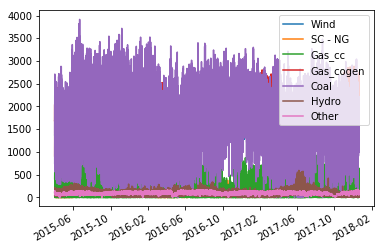

In [40]:
aeso.rename(columns={'Dispatched MW' : 'Wind', 'Peak' : 'SC - NG'}, inplace=True)
aeso[aeso.columns[[6] + list(range(8,14))]].plot.line()

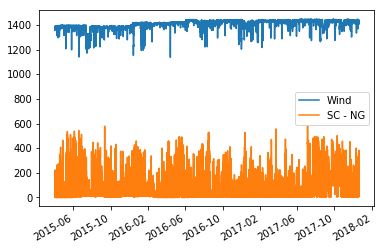

In [24]:
aeso[['Wind', 'SC - NG']].plot.line()

In [35]:
aeso.columns

Index(['Actual AIL', 'Actual Posted Pool Price',
       'Day Ahead Forecast Pool Price', 'Day-Ahead Forecasted AIL', 'Price',
       'Available MW', 'Dispatched MW', 'NG Price', 'Peak', 'Gas_cc',
       'Gas_cogen', 'Coal', 'Hydro', 'Other'],
      dtype='object')

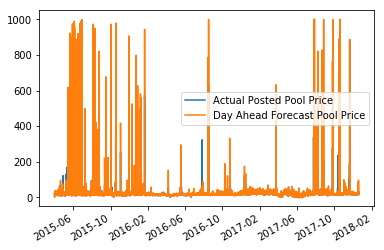

In [41]:
aeso[['Actual Posted Pool Price','Day Ahead Forecast Pool Price']].plot.line()

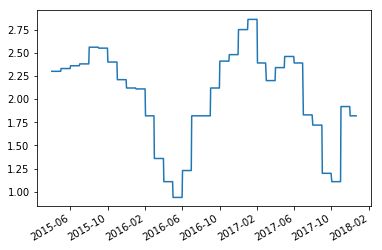

In [29]:
aeso['NG Price'].plot()

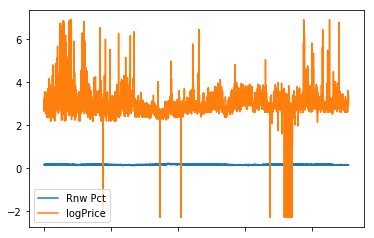

In [49]:
aeso['Rnw Pct'] = aeso['Renewables.MW']/aeso['Actual.MW']
aeso['logPrice'] = np.log(aeso['Actual.Price'])

aeso[['Rnw Pct', 'Actual.Price']].plot.line()